# LSTM Model for Heart Sound Classification

## Các điểm chính:
1. ✅ Sử dụng module preprocessing riêng biệt
2. ✅ **LSTM/GRU architecture** thay vì CNN
3. ✅ **Bidirectional LSTM** để học features từ cả 2 hướng
4. ✅ **Attention mechanism** để focus vào phần quan trọng
5. ✅ **2-class classification**: Absent vs Present
6. ✅ **5-fold Cross Validation**

In [1]:
# 1. Import thư viện
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, GRU, Dense, Dropout, 
    BatchNormalization, Attention, Concatenate, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Import module preprocessing
sys.path.append('../src')
from data_preprocessing import HeartSoundPreprocessor

print(f"TensorFlow version: {tf.__version__}")
print("✅ Đã tải tất cả thư viện!")

TensorFlow version: 2.20.0
✅ Đã tải tất cả thư viện!


## 2. Cấu hình tham số

In [2]:
# Đường dẫn
RAW_DATA_DIR = '../data/raw/training_data/'
METADATA_FILE = os.path.join(os.path.dirname(RAW_DATA_DIR.rstrip('/')), 'training_data.csv')
PROCESSED_DATA_DIR = '../data/processed_lstm_method/'
MODEL_PATH = '../results/models/lstm_model_best.h5'

# Tham số preprocessing
SR = 4000
MAX_LEN = 3000
J = 6
CUTOFF_FREQ = 500

# Tham số training
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
CV_FOLDS = 5
EARLY_STOPPING_PATIENCE = 7

# Tạo thư mục
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

print(f"📁 Thư mục dữ liệu: {os.path.abspath(RAW_DATA_DIR)}")
print(f"📁 Thư mục xử lý: {os.path.abspath(PROCESSED_DATA_DIR)}")
print(f"\n⚙️ Cấu hình:")
print(f"   - SR = {SR} Hz")
print(f"   - MAX_LEN = {MAX_LEN} samples")
print(f"   - Model: Bidirectional LSTM with Attention")

📁 Thư mục dữ liệu: C:\Users\Admin\Downloads\namCuoi\new_nc\v2\VIP\data\raw\training_data
📁 Thư mục xử lý: C:\Users\Admin\Downloads\namCuoi\new_nc\v2\VIP\data\processed_lstm_method

⚙️ Cấu hình:
   - SR = 4000 Hz
   - MAX_LEN = 3000 samples
   - Model: Bidirectional LSTM with Attention


## 3. Load và Preprocess Data

In [3]:
# Khởi tạo preprocessor
preprocessor = HeartSoundPreprocessor(
    sr=SR,
    max_len=MAX_LEN,
    cutoff_freq=CUTOFF_FREQ,
    scattering_j=J
)

print("✅ Đã khởi tạo preprocessor!")

✅ Đã khởi tạo preprocessor!


In [4]:
# Xử lý dataset
print("🔄 Bắt đầu xử lý dữ liệu...\n")

X, y = preprocessor.process_dataset(
    raw_data_dir=RAW_DATA_DIR,
    metadata_file=METADATA_FILE,
    use_scattering=True,
    verbose=True
)

🔄 Bắt đầu xử lý dữ liệu...

✅ Đã tải labels cho 874 bệnh nhân
   - Absent (0): 695
   - Present (1): 179


Processing: 100%|██████████████████████████████████████████████████████████████████| 3163/3163 [07:19<00:00,  7.20it/s]



✅ Hoàn thành!
   Total samples: 60420
   - Absent (0): 47606 (78.8%)
   - Present (1): 12814 (21.2%)
   Feature shape: (60420, 26, 47)


In [5]:
# Balance dataset
X_balanced, y_balanced = preprocessor.balance_dataset(X, y, random_state=42)

Số samples sau balancing: 25628
   - Absent (0): 12814
   - Present (1): 12814


In [6]:
# Save processed data (optional)
preprocessor.save_processed_data(X_balanced, y_balanced, PROCESSED_DATA_DIR, prefix='balanced')

✅ Đã lưu dữ liệu vào ../data/processed_lstm_method/


## 4. Split Train/Test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    stratify=y_balanced,
    random_state=42
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (20502, 26, 47)
Test set: (5126, 26, 47)


## 5. Model Architecture - Bidirectional LSTM with Attention

In [8]:
def build_lstm_attention_model(input_shape):
    """
    Bidirectional LSTM với Attention mechanism
    
    Architecture:
    - 2 Bidirectional LSTM layers (128, 64 units)
    - Attention layer để focus vào features quan trọng
    - Dense layers với Dropout
    - 2 output classes (Absent=0, Present=1)
    """
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM Layer 1
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Bidirectional LSTM Layer 2
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✅ Đã định nghĩa LSTM model architecture!")

✅ Đã định nghĩa LSTM model architecture!


In [9]:
# Xem model summary
model = build_lstm_attention_model(X_train.shape[1:])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 26, 47)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 26, 256)             │         180,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 26, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 371,522 (1.42 MB)

 Trainable params: 370,498 (1.41 MB)

 Non-trainable params: 1,024 (4.00 KB)

## 6. Alternative Model - GRU-based

In [10]:
def build_gru_model(input_shape):
    """
    Bidirectional GRU model (faster than LSTM)
    
    Architecture:
    - 2 Bidirectional GRU layers (128, 64 units)
    - Global Average Pooling
    - Dense layers với Dropout
    - 2 output classes
    """
    inputs = Input(shape=input_shape)
    
    # Bidirectional GRU Layer 1
    x = Bidirectional(GRU(128, return_sequences=True))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Bidirectional GRU Layer 2
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✅ Đã định nghĩa GRU model architecture!")

✅ Đã định nghĩa GRU model architecture!


## 7. Training với 5-Fold Cross Validation

In [11]:
# Chọn model: 'lstm' hoặc 'gru'
MODEL_TYPE = 'lstm'  # Thay đổi thành 'gru' nếu muốn dùng GRU

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
fold_acc = []

print(f"🚀 Bắt đầu Cross Validation với {MODEL_TYPE.upper()} model...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold}/{CV_FOLDS}")
    print(f"{'='*60}")
    
    # Build model
    if MODEL_TYPE == 'lstm':
        model = build_lstm_attention_model(X_train.shape[1:])
    else:
        model = build_gru_model(X_train.shape[1:])
    
    # Train
    history = model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=15,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    
    # Evaluate
    _, acc = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)
    fold_acc.append(acc)
    print(f"Validation Accuracy: {acc:.4f}")

print(f"\n{'='*60}")
print("📊 CROSS VALIDATION RESULTS")
print(f"{'='*60}")
print(f"CV Accuracies: {[f'{acc:.4f}' for acc in fold_acc]}")
print(f"Mean: {np.mean(fold_acc):.4f}")
print(f"Std: {np.std(fold_acc):.4f}")
print(f"{'='*60}")

🚀 Bắt đầu Cross Validation với LSTM model...


Fold 1/5
Validation Accuracy: 0.7952

Fold 2/5
Validation Accuracy: 0.7584

Fold 3/5
Validation Accuracy: 0.7632

Fold 4/5
Validation Accuracy: 0.7785

Fold 5/5
Validation Accuracy: 0.7802

📊 CROSS VALIDATION RESULTS
CV Accuracies: ['0.7952', '0.7584', '0.7632', '0.7785', '0.7802']
Mean: 0.7751
Std: 0.0131


## 8. Final Training & Test

In [12]:
# Build final model
if MODEL_TYPE == 'lstm':
    model = build_lstm_attention_model(X_train.shape[1:])
else:
    model = build_gru_model(X_train.shape[1:])

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

print(f"🚀 Bắt đầu final training với {MODEL_TYPE.upper()} model...\n")

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training hoàn thành!")

🚀 Bắt đầu final training với LSTM model...

Epoch 1/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6385 - loss: 0.6899

641/641 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.6628 - loss: 0.6396 - val_accuracy: 0.6810 - val_loss: 0.5803 - learning_rate: 0.0010
Epoch 2/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.6972 - loss: 0.5757 - val_accuracy: 0.6713 - val_loss: 0.5990 - learning_rate: 0.0010
Epoch 3/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.7201 - loss: 0.5487 - val_accuracy: 0.5771 - val_loss: 0.8120 - learning_rate: 0.0010
Epoch 4/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7295 - loss: 0.5322

641/641 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.7318 - loss: 0.5298 - val_accuracy: 0.7489 - val_loss: 0.5008 - learning_rate: 0.0010
Epoch 5/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.7439 - loss: 0.5178 - val_accuracy: 0.7253 - val_loss: 0.5518 - learning_rate: 0.0010
Epoch 6/50
640/641 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7494 - loss: 0.5040

641/641 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.7485 - loss: 0.5057 - val_accuracy: 0.7663 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 7/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 80s 125ms/step - accuracy: 0.7577 - loss: 0.4996 - val_accuracy: 0.6081 - val_loss: 0.7803 - learning_rate: 0.0010
Epoch 8/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 73s 113ms/step - accuracy: 0.7622 - loss: 0.4875 - val_accuracy: 0.7528 - val_loss: 0.4828 - learning_rate: 0.0010
Epoch 9/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.7629 - loss: 0.4809 - val_accuracy: 0.7544 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 10/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7655 - loss: 0.4773

641/641 ━━━━━━━━━━━━━━━━━━━━ 47s 73ms/step - accuracy: 0.7657 - loss: 0.4784 - val_accuracy: 0.7831 - val_loss: 0.4473 - learning_rate: 0.0010
Epoch 11/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 70s 109ms/step - accuracy: 0.7767 - loss: 0.4639 - val_accuracy: 0.7407 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 12/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - accuracy: 0.7764 - loss: 0.4591 - val_accuracy: 0.7128 - val_loss: 0.6277 - learning_rate: 0.0010
Epoch 13/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7841 - loss: 0.4505

641/641 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.7825 - loss: 0.4551 - val_accuracy: 0.7963 - val_loss: 0.4281 - learning_rate: 0.0010
Epoch 14/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 67s 104ms/step - accuracy: 0.7821 - loss: 0.4504 - val_accuracy: 0.7433 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 15/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.7876 - loss: 0.4402 - val_accuracy: 0.7948 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 16/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 59s 91ms/step - accuracy: 0.7927 - loss: 0.4344 - val_accuracy: 0.7794 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 17/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.8059 - loss: 0.4126 - val_accuracy: 0.7813 - val_loss: 0.4748 - learning_rate: 5.0000e-04
Epoch 18/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8035 - loss: 0.4135

641/641 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.8087 - loss: 0.4061 - val_accuracy: 0.8094 - val_loss: 0.3966 - learning_rate: 5.0000e-04
Epoch 19/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.8122 - loss: 0.4022 - val_accuracy: 0.7747 - val_loss: 0.4515 - learning_rate: 5.0000e-04
Epoch 20/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 51s 80ms/step - accuracy: 0.8114 - loss: 0.3970 - val_accuracy: 0.8061 - val_loss: 0.4053 - learning_rate: 5.0000e-04
Epoch 21/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 78s 121ms/step - accuracy: 0.8182 - loss: 0.3909 - val_accuracy: 0.8086 - val_loss: 0.4078 - learning_rate: 5.0000e-04
Epoch 22/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8293 - loss: 0.3740

641/641 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.8239 - loss: 0.3803 - val_accuracy: 0.8110 - val_loss: 0.4062 - learning_rate: 2.5000e-04
Epoch 23/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8278 - loss: 0.3668

641/641 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - accuracy: 0.8271 - loss: 0.3702 - val_accuracy: 0.8234 - val_loss: 0.3808 - learning_rate: 2.5000e-04
Epoch 24/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.8357 - loss: 0.3624 - val_accuracy: 0.8201 - val_loss: 0.3960 - learning_rate: 2.5000e-04
Epoch 25/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - accuracy: 0.8344 - loss: 0.3617 - val_accuracy: 0.8199 - val_loss: 0.3789 - learning_rate: 2.5000e-04
Epoch 26/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 43s 66ms/step - accuracy: 0.8324 - loss: 0.3617 - val_accuracy: 0.8168 - val_loss: 0.3901 - learning_rate: 2.5000e-04
Epoch 27/50
640/641 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8372 - loss: 0.3551

641/641 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8372 - loss: 0.3555 - val_accuracy: 0.8242 - val_loss: 0.3864 - learning_rate: 2.5000e-04
Epoch 28/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.8386 - loss: 0.3498 - val_accuracy: 0.8117 - val_loss: 0.3954 - learning_rate: 2.5000e-04
Epoch 29/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.8471 - loss: 0.3403 - val_accuracy: 0.8236 - val_loss: 0.3807 - learning_rate: 1.2500e-04
Epoch 30/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.8485 - loss: 0.3349 - val_accuracy: 0.8221 - val_loss: 0.3942 - learning_rate: 1.2500e-04
Epoch 31/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 46s 71ms/step - accuracy: 0.8499 - loss: 0.3343 - val_accuracy: 0.8217 - val_loss: 0.3848 - learning_rate: 1.2500e-04
Epoch 32/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8528 - loss: 0.3272

641/641 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.8502 - loss: 0.3336 - val_accuracy: 0.8250 - val_loss: 0.3766 - learning_rate: 6.2500e-05
Epoch 33/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.8535 - loss: 0.3289 - val_accuracy: 0.8223 - val_loss: 0.3923 - learning_rate: 6.2500e-05
Epoch 34/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.8494 - loss: 0.3281 - val_accuracy: 0.8248 - val_loss: 0.3810 - learning_rate: 6.2500e-05
Epoch 35/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8508 - loss: 0.3252

641/641 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.8512 - loss: 0.3267 - val_accuracy: 0.8264 - val_loss: 0.3780 - learning_rate: 6.2500e-05
Epoch 36/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 46s 71ms/step - accuracy: 0.8526 - loss: 0.3256 - val_accuracy: 0.8260 - val_loss: 0.3809 - learning_rate: 3.1250e-05
Epoch 37/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.8547 - loss: 0.3229 - val_accuracy: 0.8250 - val_loss: 0.3801 - learning_rate: 3.1250e-05
Epoch 38/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 52s 80ms/step - accuracy: 0.8536 - loss: 0.3243 - val_accuracy: 0.8246 - val_loss: 0.3757 - learning_rate: 3.1250e-05
Epoch 39/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.8543 - loss: 0.3206 - val_accuracy: 0.8260 - val_loss: 0.3850 - learning_rate: 3.1250e-05
Epoch 40/50
640/641 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8554 - loss: 0.3213

641/641 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.8546 - loss: 0.3232 - val_accuracy: 0.8272 - val_loss: 0.3788 - learning_rate: 3.1250e-05
Epoch 41/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.8570 - loss: 0.3205 - val_accuracy: 0.8268 - val_loss: 0.3811 - learning_rate: 3.1250e-05
Epoch 42/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.8565 - loss: 0.3184 - val_accuracy: 0.8260 - val_loss: 0.3820 - learning_rate: 1.5625e-05
Epoch 43/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.8556 - loss: 0.3178 - val_accuracy: 0.8268 - val_loss: 0.3771 - learning_rate: 1.5625e-05
Epoch 44/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.8595 - loss: 0.3165 - val_accuracy: 0.8258 - val_loss: 0.3808 - learning_rate: 1.5625e-05
Epoch 45/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.8586 - loss: 0.3175 - val_accuracy: 0.8268 - val_loss: 0.3771 - learning_rate: 7.8125e-06

✅ Training hoàn thành!


## 9. Evaluation

161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


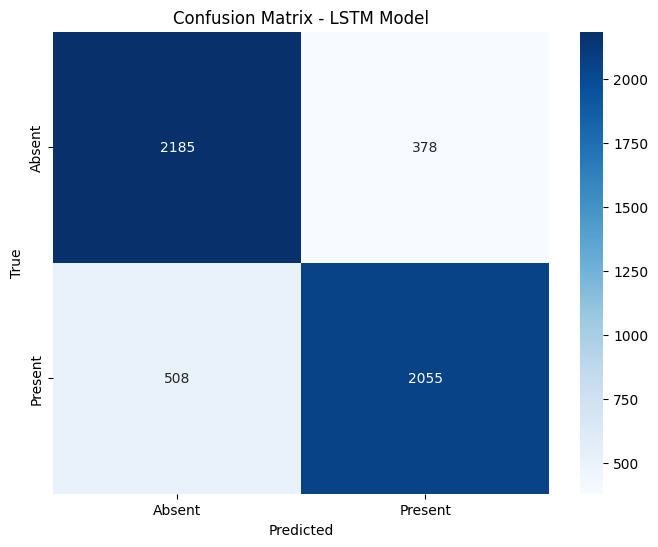


📊 CLASSIFICATION REPORT - LSTM MODEL
              precision    recall  f1-score   support

      Absent       0.81      0.85      0.83      2563
     Present       0.84      0.80      0.82      2563

    accuracy                           0.83      5126
   macro avg       0.83      0.83      0.83      5126
weighted avg       0.83      0.83      0.83      5126


Test Accuracy: 0.8272


In [13]:
# Load best model
from tensorflow.keras.models import load_model
model = load_model(MODEL_PATH)

# Predict
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Absent', 'Present'],
    yticklabels=['Absent', 'Present']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {MODEL_TYPE.upper()} Model')
plt.show()

# Classification Report
print("\n" + "="*60)
print(f"📊 CLASSIFICATION REPORT - {MODEL_TYPE.upper()} MODEL")
print("="*60)
print(classification_report(
    y_test, y_pred,
    target_names=['Absent', 'Present']
))

# Test Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_acc:.4f}")
print("="*60)

## 10. Training History

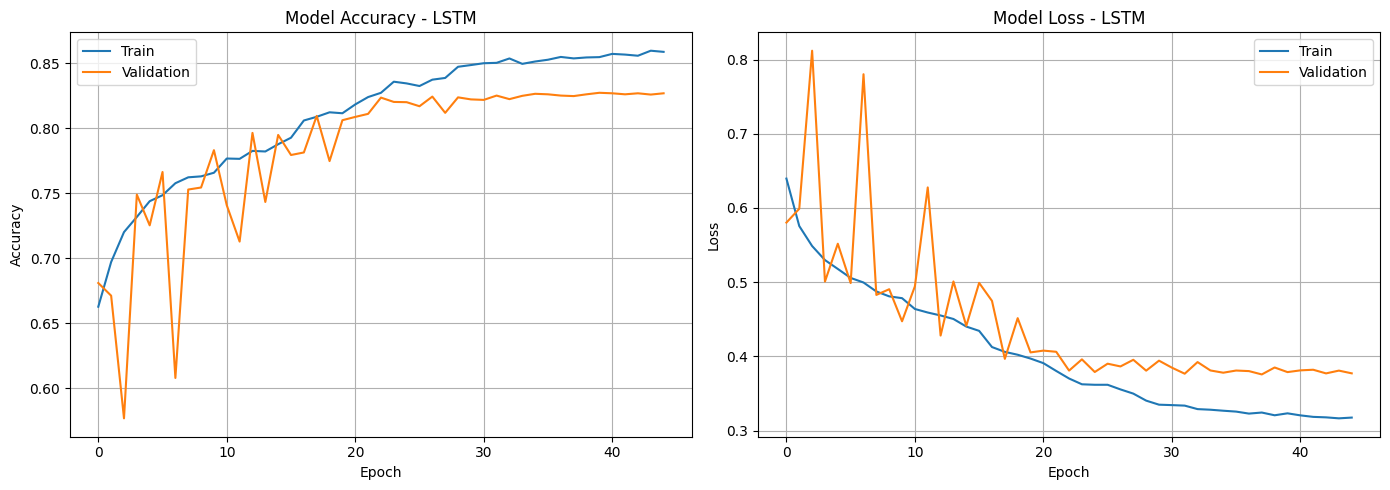

In [14]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title(f'Model Accuracy - {MODEL_TYPE.upper()}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title(f'Model Loss - {MODEL_TYPE.upper()}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. So sánh với CNN Model

In [15]:
# Load CNN model để so sánh (nếu có)
CNN_MODEL_PATH = '../results/models/1dcnn_method_best.h5'

if os.path.exists(CNN_MODEL_PATH):
    print("📊 So sánh LSTM vs CNN Model:\n")
    
    cnn_model = load_model(CNN_MODEL_PATH)
    y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
    cnn_acc = accuracy_score(y_test, y_pred_cnn)
    
    print(f"CNN Model Accuracy:  {cnn_acc:.4f}")
    print(f"{MODEL_TYPE.upper()} Model Accuracy: {test_acc:.4f}")
    print(f"\nDifference: {(test_acc - cnn_acc)*100:+.2f}%")
else:
    print("⚠️ CNN model không tồn tại để so sánh")

📊 So sánh LSTM vs CNN Model:



161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
CNN Model Accuracy:  0.8346
LSTM Model Accuracy: 0.8272

Difference: -0.74%
